# time during the year when maximum five-day period occurs
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.formula.api import ols as reg

Data location

In [2]:
loc_in = "../Data/Tx5d/"
loc_shp = "../Data/Shapefile/"

Functions for averaging

In [3]:
def transform_from_latlon(lat, lon):
    # Written by Alex Gottlieb
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale
def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))
def flip_lon_tll(da):
    # flip 360 to 180 lon
    # for time-lat-lon xarray dataarray

    # get coords
    lat_da = da.coords["lat"]
    lon_da = da.coords["lon"]
    time_da = da.coords["time"]

    # flip lon
    lon_180 = (lon_da.values + 180) % 360 - 180

    # new data array
    da_180 = xr.DataArray(da.values,
                          coords=[time_da,lat_da.values,lon_180],
                          dims=["time","lat","lon"])

    # flip dataarray so it goes from -180 to 180
    # (instead of 0-180, -180-0)
    lon_min_neg = np.amin(lon_180[lon_180<0])
    lon_max_neg = np.amax(lon_180[lon_180<0])
    lon_min_pos = np.amin(lon_180[lon_180>=0])
    lon_max_pos = np.amax(lon_180[lon_180>=0])
    da_180_flip = xr.concat([da_180.loc[:,:,lon_min_neg:lon_max_neg],
                             da_180.loc[:,:,lon_min_pos:lon_max_pos]],
                            dim="lon")
    return(da_180_flip)
def xr_region_average(data,y1,y2,freq,shapes,id_list,idnums_dict):

    time = pd.date_range(start=str(y1)+"-01-01",end=str(y2)+"-12-31",freq=freq)
    if freq=="D":
        time = time[(time.month!=2)|(time.day!=29)]
    region_array = xr.DataArray(np.full((len(id_list),len(time)),np.nan),
                                 coords=[id_list,time],
                                 dims=["id","time"])

    idraster = rasterize(shapes,data.drop("time").coords)
    data.coords["region"] = idraster
    regionmean = data.groupby("region").mean()

    idcoord = np.array([idnums_dict[n] for n in regionmean.coords["region"].values])
    region_array.loc[idcoord,:] = regionmean.transpose("region","time").values
    return(region_array)
def xr_region_std(data,y1,y2,freq,shapes,id_list,idnums_dict):

    time = pd.date_range(start=str(y1)+"-01-01",end=str(y2)+"-12-31",freq=freq)
    if freq=="D":
        time = time[(time.month!=2)|(time.day!=29)]
    region_array = xr.DataArray(np.full((len(id_list),len(time)),np.nan),
                                 coords=[id_list,time],
                                 dims=["id","time"])

    idraster = rasterize(shapes,data.drop("time").coords)
    data.coords["region"] = idraster
    regionstd = data.groupby("region").std()

    idcoord = np.array([idnums_dict[n] for n in regionstd.coords["region"].values])
    region_array.loc[idcoord,:] = regionstd.transpose("region","time").values
    return(region_array)

#### Analysis

Shapefile

In [4]:
shp = gp.read_file(loc_shp+"gadm36_1.shp")
id_shp = shp.GID_1.values
idnums = {i: k for i, k in enumerate(shp.GID_1)}
#isonums_rev = {k: i for i, k in enumerate(shp.ISO3)}
shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]

data

In [5]:
y1 = 1979
y2 = 2016

In [7]:
doy_data = xr.open_dataarray(loc_in+"ERA5_Tx5d_dayofyear_"+str(y1)+"-"+str(y2)+".nc")
doy_data_shshift = xr.open_dataarray(loc_in+"ERA5_Tx5d_dayofyear_shshift_"+str(y1)+"-"+str(y2)+".nc")

Now calculate regional average and standard deviation

In [11]:
doy_flip = flip_lon_tll(doy_data[:,::-1,:])
doy_flip_shshift = flip_lon_tll(doy_data_shshift[:,::-1,:])

In [34]:
# chop off the first year because of the shift
doy_region_mean = xr_region_average(doy_flip_shshift[1:],y1+1,y2,"YS",shapes,id_shp,idnums)
doy_region_std = xr_region_std(doy_flip_shshift[1:],y1+1,y2,"YS",shapes,id_shp,idnums)

In [51]:
#doy_region_std_nh = xr_region_std(doy_flip.loc[:,0.25:89.75,:],y1,y2,"YS",shapes,id_shp,idnums)

Map and histogram

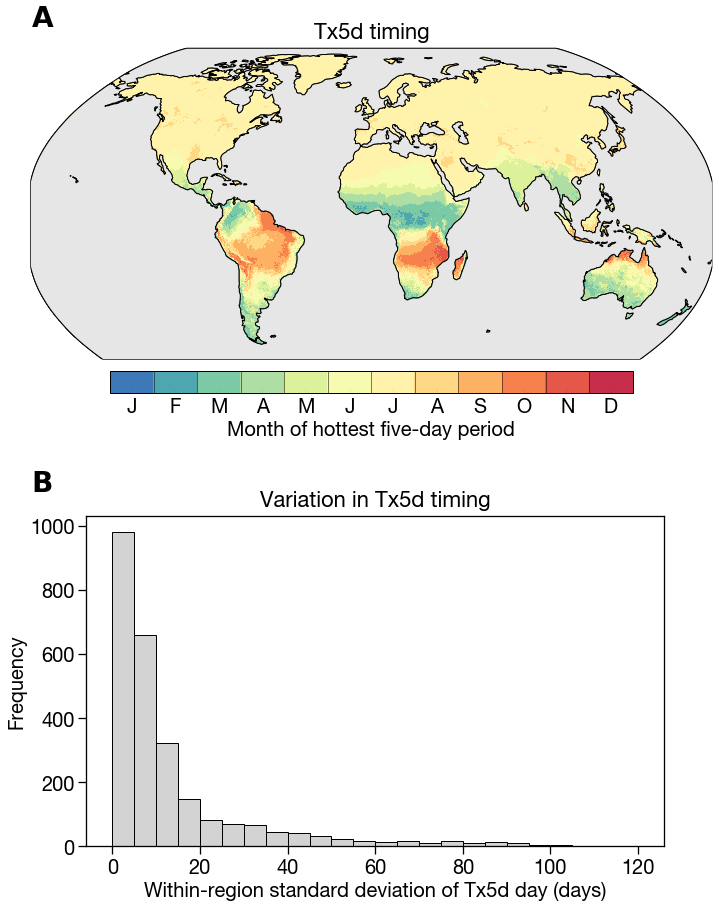

In [55]:
fig = plt.figure(figsize=(11,17))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 4
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 4
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.1,right=0.96,top=0.9,bottom=0.55,wspace=0.03,hspace=0.2)

# set up axis/projection
ax = plt.subplot(gs1[0,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
ax.coastlines()

# choose color levels
cmin = 0
cmax = 365
nrange = 36
#bounds = np.linspace(cmin,cmax,nrange)
bounds = [0,31,59,90,120,151,181,212,243,273,304,334,365]
cols = plt.get_cmap('Spectral_r')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

doy_data.mean(dim="time").plot(ax=ax,transform=ccrs.PlateCarree(),
         cmap=cmap,norm=norm,add_colorbar=False)

# add fill
ax.add_feature(cart.feature.OCEAN,zorder=100,edgecolor='black',facecolor=[0.9,0.9,0.9])

# title
plt.title("Tx5d timing",pad=10,fontsize=22)

# color bar
cbar_tks = [(bounds[x]+bounds[x+1])/2.0 for x in np.arange(0,len(bounds)-1,1)]
cbar_lbs = ["J","F","M","A","M","J","J","A","S","O","N","D"]
cbar_ax = fig.add_axes([0.2,0.57,0.66,0.018])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                  drawedges=True,extend="neither",
                 ticks=cbar_tks)
cbar_ax.tick_params(direction="in",width=0.05)
cbar_ax.set_xticklabels(cbar_lbs)
cb.set_label("Month of hottest five-day period",rotation=0)



## histogram

gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.17,right=0.9,top=0.47,bottom=0.2,wspace=0.25,hspace=0.3)
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
ax = plt.subplot(gs2[0,0])

plt.hist(doy_region_std.mean(dim="time"),
        bins=np.arange(0,120+5,5),facecolor="lightgray",edgecolor="black")

plt.ylabel("Frequency")
plt.xlabel("Within-region standard deviation of Tx5d day (days)")

#plt.text(0.59,0.88,"Northern Hemisphere only",fontsize=18,transform=ax.transAxes)
plt.title("Variation in Tx5d timing",fontsize=22,pad=10)


plt.figtext(0.1,0.87,r'$\bf{A}$',fontsize=28)
plt.figtext(0.1,0.49,r'$\bf{B}$',fontsize=28)

plt.savefig("../Figures/FigX_Tx5d_DOY.png")

plt.show()

In [45]:
daysinmon = np.array([pd.Period("2018-"+str(x)+"-04").days_in_month for x in np.arange(1,12+1,1)])

In [46]:
np.cumsum(daysinmon)

array([ 31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334, 365])

In [36]:
x = doy_region_std.mean(dim="time")[~np.isnan(doy_region_std.mean(dim="time"))]

In [37]:
lenx = len(x)

In [38]:
len(x[x<14])/lenx

0.7412128234839707